# OU Feature Engineering
#### This notebook is for doing feature engineering for the supervised learning (classification) problem for our capstone

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_data():
    assessments_raw = pd.read_csv("dataset/assessments.csv")
    courses_raw = pd.read_csv("dataset/courses.csv")
    student_assessment_raw = pd.read_csv("dataset/studentAssessment.csv")
    student_info_raw = pd.read_csv("dataset/studentInfo.csv")
    student_registration_raw = pd.read_csv("dataset/studentRegistration.csv")
    # If this is failing, ensure that you have downloaded the dataset and copied studentVle.csv 
    # to the dataset folder.
    student_vle_raw = pd.read_csv("dataset/studentVle.csv") 
    vle_raw = pd.read_csv("dataset/vle.csv")

    return {
        "assessments_raw":assessments_raw,
        "courses_raw":courses_raw,
        "student_assessment_raw":student_assessment_raw,
        "student_info_raw":student_info_raw,
        "student_registration_raw":student_registration_raw,
        "student_vle_raw":student_vle_raw,
        "vle_raw":vle_raw
    }

In [4]:
# this is only used for testing purposes - comment out before saving as a module
#data_dict = get_data()

#### Add column indicating if student previously failed

In [128]:
def did_not_prev_pass(df):
    if len(df['final_result_y']) == 1:
        return False
    zipped = zip(df['code_presentation_y'], df['final_result_y'])
    
    # remove presentations that are at the same time of the current one or after
    curr_presentation = df['code_presentation_x']
    prior_final_results = [x[1] for x in zipped if x[0] < curr_presentation]

    dnp_set = {"Withdrawn", "Fail"}
    if len(dnp_set & set(prior_final_results)) > 0:
        return True
    return False
    
    

# create a column that indicates whether or not the student has previously withdrawn or failed
def add_col_student_prev_failed(student_info_df):
    '''
    Given the student info dataframe, add a column to indicate 
    '''
    si = student_info_df.copy()

    # this is a list of all students final results for each presentation
    si_grouped = si[['id_student','code_module','code_presentation','final_result']].groupby(['id_student']).agg(list).reset_index()
    merged = si.merge(si_grouped, left_on='id_student', right_on='id_student')
    merged['prev_failed_or_withdrawn'] = merged.apply(did_not_prev_pass, axis=1)

    print(si_grouped.columns)
    print(merged.columns)

    si = si.merge(
                merged[['id_student','prev_failed_or_withdrawn', 'code_presentation_x','code_module_x']], 
                left_on=['id_student','code_presentation','code_module'],
                right_on=['id_student','code_presentation_x','code_module_x']
            ).drop(
                columns=['code_presentation_x','code_module_x']
            )
    #si['has_prev_withdrawn_or_failed']
    return si

In [127]:
# test that it doesn't change number of rows, and increases columns by 1
# si_test = si[si.id_student == 8462]
#si_prev_failed = add_student_prev_failed(si)
#print(si_prev_failed.shape)
#print(si.shape)

Index(['id_student', 'code_module', 'code_presentation', 'final_result'], dtype='object')
Index(['code_module_x', 'code_presentation_x', 'id_student', 'gender',
       'region', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability',
       'final_result_x', 'code_module_y', 'code_presentation_y',
       'final_result_y', 'prev_failed_or_withdrawn'],
      dtype='object')
(32593, 13)
(32593, 12)


<AxesSubplot:>

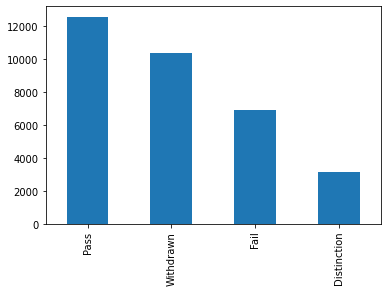

In [103]:

# is the distribution of final_result of the students who have previously failed/withdrawn different from 
# the other students?
# Answer: it appears that they are different from the two plots. Commented out to make this notebook import friendly!

# import matplotlib.pyplot as plt

# si_prev_failed[si_prev_failed.prev_failed == False]['final_result'].value_counts().plot(kind='bar')

<AxesSubplot:>

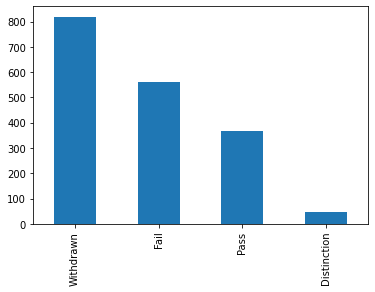

In [104]:
# si_prev_failed[si_prev_failed.prev_failed == True]['final_result'].value_counts().plot(kind='bar')

#### Add column indicating if student is minority

In [313]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def add_col_is_student_minority(student_info_df):
    si = student_info_df.copy()

    # student being a minority can different from class to class. Create a clustering 
    # for each module-presentation
    #print(si.head())
    si_grouped = si.groupby(['code_module','code_presentation'])

    minority_columns = ['highest_education','age_band','disability','gender','imd_band']

    df_class_list = [v for k,v in si_grouped]
    count = 0
    for df in df_class_list:
        df_with_dummies = pd.get_dummies(df[minority_columns])
        print(df_with_dummies.columns)
        num_students = df.shape[0]
        clustering = DBSCAN(eps=1.4143, min_samples=int(.1*num_students)).fit(df_with_dummies)
        df_with_dummies['cluster'] = clustering.labels_
        df['cluster'] = clustering.labels_
        print(df_with_dummies['cluster'].value_counts())
        plot_NN_distances(df_with_dummies)
        #plot_pca(df_with_dummies, 'cluster')
        #plot_tsne(df, 'cluster')
        if count >= 0:
            break
        count += 1
    

    return df_class_list


Index(['highest_education_A Level or Equivalent',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_Post Graduate Qualification', 'age_band_0-35',
       'age_band_35-55', 'age_band_55<=', 'disability_N', 'disability_Y',
       'gender_F', 'gender_M', 'imd_band_0-10%', 'imd_band_10-20',
       'imd_band_20-30%', 'imd_band_30-40%', 'imd_band_40-50%',
       'imd_band_50-60%', 'imd_band_60-70%', 'imd_band_70-80%',
       'imd_band_80-90%', 'imd_band_90-100%'],
      dtype='object')
 0    365
-1     18
Name: cluster, dtype: int64
   highest_education_A Level or Equivalent  \
0                                        0   
1                                        0   
2                                        1   
3                                        1   
4                                        0   

   highest_education_HE Qualification  highest_education_Lower Than A Level  \
0                                   1      

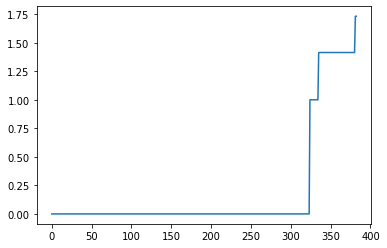

In [316]:
test_ = add_col_is_student_minority(si)
#test_[0][test_[0].cluster == -1]

In [315]:
from sklearn.decomposition import PCA
import seaborn as sns 

# code adapted from: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
def plot_NN_distances(df):
    print(df.head())
    # plot distances - used for determining epsilon of dbscan
    num_students = df.shape[0]
    neigh = NearestNeighbors(n_neighbors=10)
    nbrs = neigh.fit(df)
    distances, indices = nbrs.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    #print(distances)
    plt.plot(distances)


# code adapted from: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
def plot_pca(df, label_column):
    # plot dataframe using PCA and coloring on label_column
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df.drop(columns=label_column).values)
    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1]
    sns.scatterplot(
        x='pca-one',
        y='pca-two',
        hue=label_column,
        data=df
    )
    plt.show()


#def plot_tsne(df, label_colum):
#    # plot df using tsne for dimension reduction and color on label_column

In [312]:

#print(si.sample(frac=1).head())
#add_col_is_student_minority(si.sample(frac=1))

In [148]:
si_grouped_test = [v for k, v in si.groupby(['code_module','code_presentation'])]
print(si_grouped_test[0].head())
print(si_grouped_test[1].head())

#si_grouped_keys = list(si_grouped_test.groups.keys())
#si_grouped_test.iloc[si_grouped_test.groups[si_grouped_keys[0]]]


  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   

   studied_credits disability final_result  
0              240          N         Pass  
1               60          N         Pass  